In [1]:
#1차 데이터 전처리 특성중요도 0.07미만 제거
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# 데이터 불러오기
data = pd.read_csv('./data.csv')

# 특성과 타겟 변수 분리
data_input = data.drop(columns=['Bankrupt?'])
data_target = data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(train_input, train_target)

# 특성 중요도 확인
importances = rf_model.feature_importances_
features = data_input.columns
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# 중요도가 낮은 특성 제거 (중요도 0.07 미만인 특성 제거)
important_features = feature_importances[feature_importances['Importance'] > 0.007]['Feature']
data_input_reduced = data_input[important_features]

# 중요한 특성만 포함한 데이터프레임에 타겟 변수 'Bankrupt?' 컬럼 추가
data_reduced_with_target = data_input_reduced.copy()
data_reduced_with_target['Bankrupt?'] = data_target


data_reduced_with_target.to_csv('./data_reduced.csv', index=False)



샘플 크기: 200, 훈련 세트 정확도: 0.9206349206349206, 테스트 세트 정확도: 0.9047619047619048, 교차 검증 평균 정확도: 0.8857142857142858, 재현율: 0.8983050847457628
샘플 크기: 300, 훈련 세트 정확도: 0.9307692307692308, 테스트 세트 정확도: 0.9230769230769231, 교차 검증 평균 정확도: 0.8826923076923077, 재현율: 0.9148936170212766
샘플 크기: 400, 훈련 세트 정확도: 0.9483870967741935, 테스트 세트 정확도: 0.8903225806451613, 교차 검증 평균 정확도: 0.8870967741935484, 재현율: 0.8524590163934426
샘플 크기: 500, 훈련 세트 정확도: 0.9259259259259259, 테스트 세트 정확도: 0.9, 교차 검증 평균 정확도: 0.8861111111111111, 재현율: 0.8275862068965517
샘플 크기: 600, 훈련 세트 정확도: 0.9512195121951219, 테스트 세트 정확도: 0.8731707317073171, 교차 검증 평균 정확도: 0.8853658536585366, 재현율: 0.7272727272727273
샘플 크기: 700, 훈련 세트 정확도: 0.9405797101449276, 테스트 세트 정확도: 0.8782608695652174, 교차 검증 평균 정확도: 0.8902173913043478, 재현율: 0.7209302325581395
샘플 크기: 800, 훈련 세트 정확도: 0.9516339869281045, 테스트 세트 정확도: 0.8901960784313725, 교차 검증 평균 정확도: 0.8970588235294118, 재현율: 0.6326530612244898
샘플 크기: 900, 훈련 세트 정확도: 0.9595238095238096, 테스트 세트 정확도: 0.8892857142857142, 교차 검증 평균 

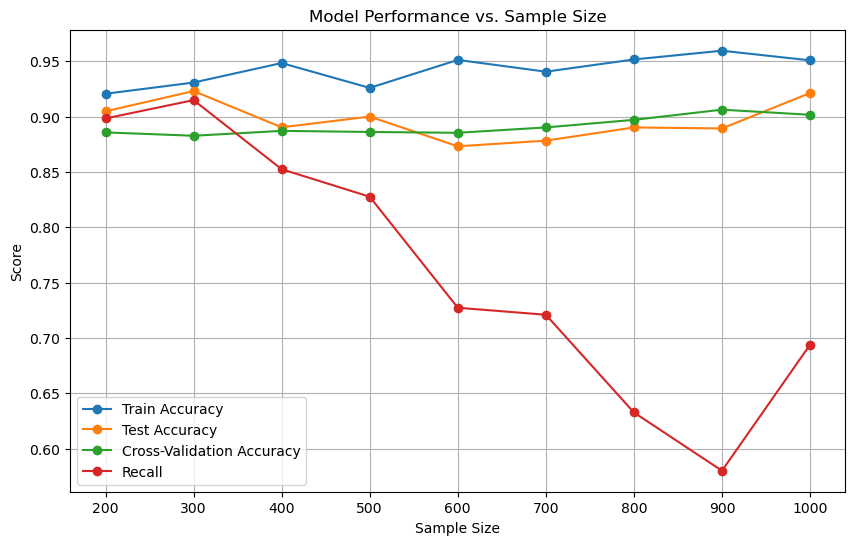

In [2]:
#전체 데이터에서 그리드서치 사용했을 때 최적의 0 개수 찾기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

data = pd.read_csv('./data_reduced.csv')

sample_sizes = range(200, 1001, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []

# 고정된 random_state를 사용하여 데이터 샘플링 유지
for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = data[data['Bankrupt?'] == 0].sample(size, random_state=41)
    Training_data_1 = data[data['Bankrupt?'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=41).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']

    # 데이터 분리
    train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
        data_input_reduced, data_target, random_state=42)

    # 랜덤 포레스트 모델 학습
    rf_model_reduced = RandomForestClassifier(random_state=42)
    rf_model_reduced.fit(train_input_reduced, train_target_reduced)

    # 하이퍼파라미터 튜닝
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [10, 15],
        'min_samples_leaf': [4, 6],
        'bootstrap': [True]
    }

    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               scoring='accuracy')
    grid_search.fit(train_input_reduced, train_target_reduced)

    best_rf_model = grid_search.best_estimator_

    # 최적의 하이퍼파라미터로 모델 재학습
    best_rf_model.fit(train_input_reduced, train_target_reduced)

    # 예측 (하이퍼파라미터 튜닝 후)
    train_predictions_tuned = best_rf_model.predict(train_input_reduced)
    test_predictions_tuned = best_rf_model.predict(test_input_reduced)

    # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
    train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
    test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
    recall_tuned = recall_score(test_target_reduced, test_predictions_tuned)

    train_accuracy_results.append(train_accuracy_tuned)
    test_accuracy_results.append(test_accuracy_tuned)
    recall_results.append(recall_tuned)

    # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
    cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
    cv_accuracy_tuned = np.mean(cv_scores_tuned)
    cv_accuracy_results.append(cv_accuracy_tuned)

    print(f"샘플 크기: {size}, 훈련 세트 정확도: {train_accuracy_tuned}, 테스트 세트 정확도: {test_accuracy_tuned}, 교차 검증 평균 정확도: {cv_accuracy_tuned}, 재현율: {recall_tuned}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.plot(sample_sizes, recall_results, marker='o', label='Recall')
plt.xlabel('Sample Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()


샘플 크기: 200, 훈련 세트 정확도: 0.9650793650793651, 테스트 세트 정확도: 0.9047619047619048, 교차 검증 평균 정확도: 0.8785714285714287, 재현율: 0.8983050847457628
샘플 크기: 300, 훈련 세트 정확도: 0.982051282051282, 테스트 세트 정확도: 0.9230769230769231, 교차 검증 평균 정확도: 0.8846153846153847, 재현율: 0.9148936170212766
샘플 크기: 400, 훈련 세트 정확도: 0.9741935483870968, 테스트 세트 정확도: 0.8903225806451613, 교차 검증 평균 정확도: 0.8887096774193548, 재현율: 0.8688524590163934
샘플 크기: 500, 훈련 세트 정확도: 0.9685185185185186, 테스트 세트 정확도: 0.8944444444444445, 교차 검증 평균 정확도: 0.888888888888889, 재현율: 0.8275862068965517
샘플 크기: 600, 훈련 세트 정확도: 0.983739837398374, 테스트 세트 정확도: 0.8634146341463415, 교차 검증 평균 정확도: 0.8841463414634146, 재현율: 0.7454545454545455
샘플 크기: 700, 훈련 세트 정확도: 0.9405797101449276, 테스트 세트 정확도: 0.8739130434782608, 교차 검증 평균 정확도: 0.8869565217391304, 재현율: 0.7209302325581395
샘플 크기: 800, 훈련 세트 정확도: 0.9790849673202614, 테스트 세트 정확도: 0.8980392156862745, 교차 검증 평균 정확도: 0.9009803921568628, 재현율: 0.6530612244897959
샘플 크기: 900, 훈련 세트 정확도: 0.9619047619047619, 테스트 세트 정확도: 0.896428571428571

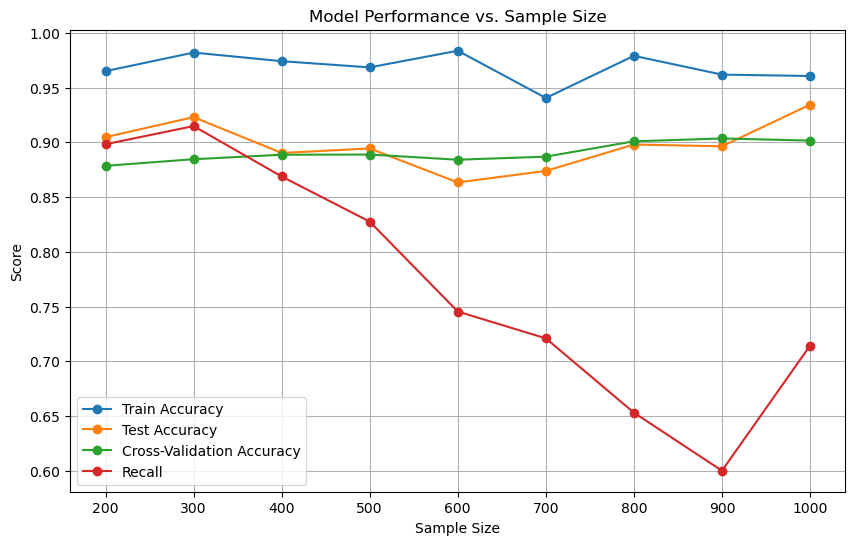

In [3]:
#전체 데이터에서 랜덤서치 사용했을 때 최적의 0 개수 찾기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score
from scipy.stats import randint

# 데이터 불러오기
data = pd.read_csv('./data_reduced.csv')

sample_sizes = range(200, 1001, 100)
train_accuracy_results = []
test_accuracy_results = []
cv_accuracy_results = []
recall_results = []

# 고정된 random_state를 사용하여 데이터 샘플링 유지
for size in sample_sizes:
    # 언더샘플링
    Training_data_0 = data[data['Bankrupt?'] == 0].sample(size, random_state=41)
    Training_data_1 = data[data['Bankrupt?'] == 1]
    Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=41).reset_index(drop=True)

    # 특성과 타겟 변수 분리
    data_input_reduced = Undersample_data.drop(columns=['Bankrupt?'])
    data_target = Undersample_data['Bankrupt?']

    # 데이터 분리
    train_input_reduced, test_input_reduced, train_target_reduced, test_target_reduced = train_test_split(
        data_input_reduced, data_target, random_state=42)

    # 랜덤 포레스트 모델 학습
    rf_model_reduced = RandomForestClassifier(random_state=42)
    rf_model_reduced.fit(train_input_reduced, train_target_reduced)

    # 하이퍼파라미터 튜닝 (랜덤 서치)
    param_dist = {
        'n_estimators': randint(100, 200),
        'max_depth': randint(5, 15),
        'min_samples_split': randint(10, 20),
        'min_samples_leaf': randint(4, 10),
        'bootstrap': [True, False]
    }

    random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                       param_distributions=param_dist,
                                       n_iter=100,
                                       cv=5,
                                       n_jobs=-1,
                                       scoring='accuracy',
                                       random_state=42)
    random_search.fit(train_input_reduced, train_target_reduced)

    best_rf_model = random_search.best_estimator_

    # 최적의 하이퍼파라미터로 모델 재학습
    best_rf_model.fit(train_input_reduced, train_target_reduced)

    # 예측 (하이퍼파라미터 튜닝 후)
    train_predictions_tuned = best_rf_model.predict(train_input_reduced)
    test_predictions_tuned = best_rf_model.predict(test_input_reduced)

    # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
    train_accuracy_tuned = accuracy_score(train_target_reduced, train_predictions_tuned)
    test_accuracy_tuned = accuracy_score(test_target_reduced, test_predictions_tuned)
    recall_tuned = recall_score(test_target_reduced, test_predictions_tuned)

    train_accuracy_results.append(train_accuracy_tuned)
    test_accuracy_results.append(test_accuracy_tuned)
    recall_results.append(recall_tuned)

    # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
    cv_scores_tuned = cross_val_score(best_rf_model, data_input_reduced, data_target, cv=5)
    cv_accuracy_tuned = np.mean(cv_scores_tuned)
    cv_accuracy_results.append(cv_accuracy_tuned)

    print(f"샘플 크기: {size}, 훈련 세트 정확도: {train_accuracy_tuned}, 테스트 세트 정확도: {test_accuracy_tuned}, 교차 검증 평균 정확도: {cv_accuracy_tuned}, 재현율: {recall_tuned}")

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_accuracy_results, marker='o', label='Train Accuracy')
plt.plot(sample_sizes, test_accuracy_results, marker='o', label='Test Accuracy')
plt.plot(sample_sizes, cv_accuracy_results, marker='o', label='Cross-Validation Accuracy')
plt.plot(sample_sizes, recall_results, marker='o', label='Recall')
plt.xlabel('Sample Size')
plt.ylabel('Score')
plt.title('Model Performance vs. Sample Size')
plt.legend()
plt.grid(True)
plt.show()


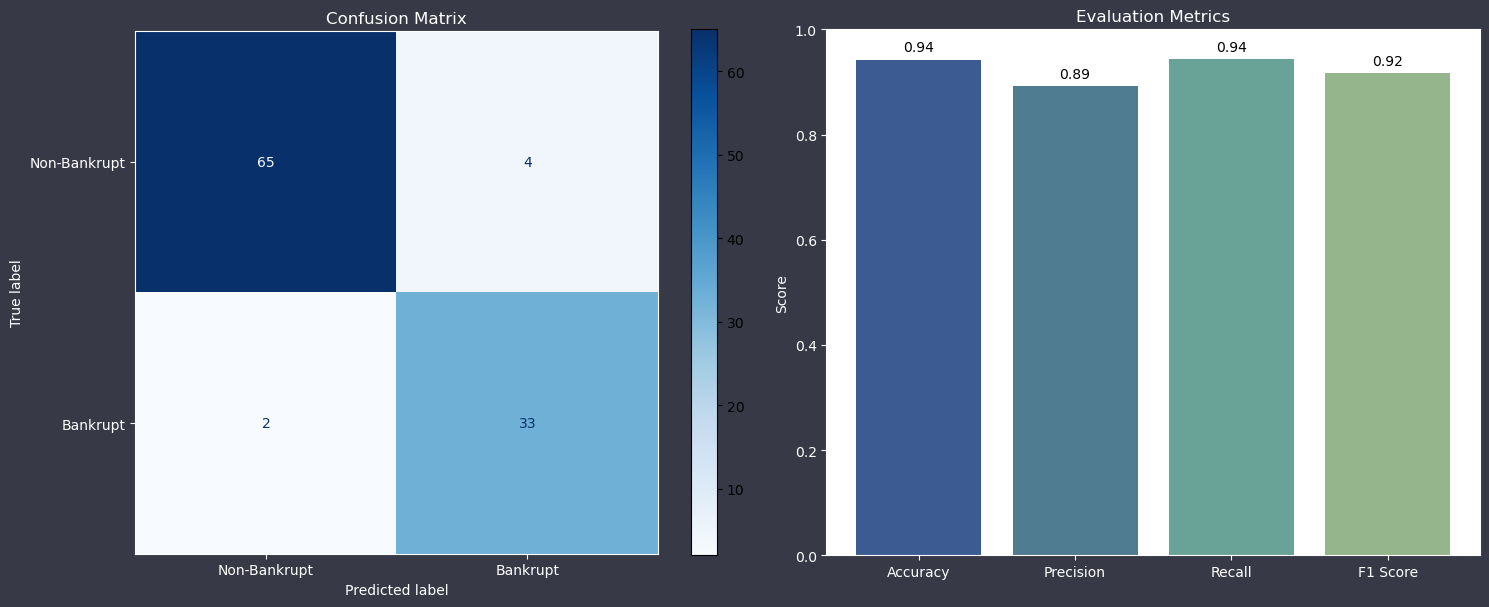

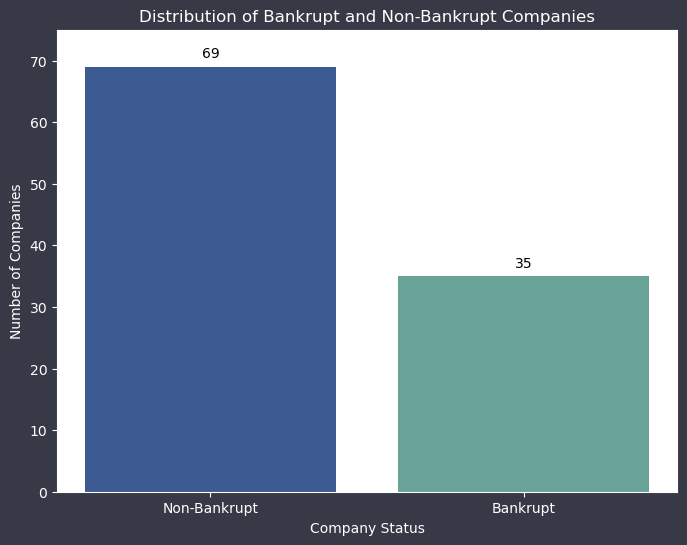

검증 학습데이터 정확도 :0.9495192307692307
검증 평가데이터 정확도 :0.9423076923076923
교차검증 결과 평균 :0.8685840504876648
최적 하이퍼파라미터 값 :RandomForestClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=161, random_state=42)


In [12]:
# 0인 샘플 300고정, 랜덤포레스트 - 랜덤서치 교차검증(sub, val set)

# 데이터 불러오기
data = pd.read_csv('./data_reduced.csv')

# 언더샘플링
Training_data_0 = data[data['Bankrupt?'] == 0].sample(300, random_state=41)
Training_data_1 = data[data['Bankrupt?'] == 1]
Undersample_data = pd.concat([Training_data_0, Training_data_1]).sample(frac=1, random_state=41).reset_index(drop=True)

# 특성과 타겟 변수 분리
data_input = Undersample_data.drop(columns=['Bankrupt?'])
data_target = Undersample_data['Bankrupt?']

# 데이터 분리
train_input, test_input, train_target, test_target = train_test_split(
    data_input, data_target, test_size=0.2, random_state=42)

# 하이퍼파라미터 튜닝 (랜덤 서치)
param_dist = {
    'n_estimators': randint(100, 200),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(10, 20),
    'min_samples_leaf': randint(4, 10)
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                    param_distributions=param_dist,
                                    n_iter=150,
                                    cv=5,
                                    n_jobs=-1,
                                    scoring='accuracy',
                                    random_state=42)
random_search.fit(train_input, train_target)

best_rf_model = random_search.best_estimator_

# 교차 검증 결과 보기
cv_results = random_search.cv_results_
cv_scores = cv_results['mean_test_score']

# 최적의 하이퍼파라미터로 모델 재학습
best_rf_model.fit(train_input, train_target)

# 예측 (하이퍼파라미터 튜닝 후)
train_predictions_tuned = best_rf_model.predict(train_input)
test_predictions_tuned = best_rf_model.predict(test_input)

# 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
train_accuracy_tuned = accuracy_score(train_target, train_predictions_tuned)
test_accuracy_tuned = accuracy_score(test_target, test_predictions_tuned)

# 평가 지표 계산
accuracy = accuracy_score(test_target, test_predictions_tuned)
precision = precision_score(test_target, test_predictions_tuned)
recall = recall_score(test_target, test_predictions_tuned)
f1 = f1_score(test_target, test_predictions_tuned)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(test_target, test_predictions_tuned)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.patch.set_facecolor('#373947')  # 배경 색상 설정

# 혼동 행렬 시각화
ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix', color='white')
axes[0].set_xlabel('Predicted label', color='white')
axes[0].set_ylabel('True label', color='white')
axes[0].tick_params(colors='white')
for spine in axes[0].spines.values():
    spine.set_edgecolor('white')

# 평가 지표 시각화
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [accuracy, precision, recall, f1]
colors = ['#3b5b92', '#4f7c91', '#69a297', '#95b68c']
bars = axes[1].bar(metrics, scores, color=colors)
axes[1].set_ylim(0, 1)
axes[1].set_title('Evaluation Metrics', color='white')
axes[1].set_ylabel('Score', color='white')
axes[1].tick_params(colors='white')
for spine in axes[1].spines.values():
    spine.set_edgecolor('white')

# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# 타겟 변수 분포 확인
target_counts = test_target.value_counts()

# 불균형 데이터 시각화
plt.figure(figsize=(8, 6))
plt.gcf().set_facecolor('#373947')  # 배경 색상 설정
colors_distribution = ['#3B5B92', '#69A297']  # 두 번째 그래프의 색상에 맞춰 수정
bars = plt.bar(target_counts.index, target_counts.values, color=colors_distribution)
plt.xticks(target_counts.index, ['Non-Bankrupt', 'Bankrupt'])
plt.ylim(0, 75)
plt.xlabel('Company Status', color='white')
plt.ylabel('Number of Companies', color='white')
plt.title('Distribution of Bankrupt and Non-Bankrupt Companies', color='white')
plt.gca().set_facecolor('white') #전체배경색
plt.gca().tick_params(colors='white')
for spine in plt.gca().spines.values():
    spine.set_edgecolor('white')
# 막대 위에 수치 표시
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', color='black')
plt.show()

print(f'검증 학습데이터 정확도 :{train_accuracy_tuned}')
print(f'검증 평가데이터 정확도 :{test_accuracy_tuned}')
# print(f'교차검증 결과 : {cv_results}')
print(f'교차검증 결과 평균 :{np.mean(cv_scores)}')
print(f'최적 하이퍼파라미터 값 :{best_rf_model}')

In [5]:
# # # test set (최종 검증)

# random_search.fit(sub_input, sub_target)

# best_rf_model = random_search.best_estimator_

# # 최적의 하이퍼파라미터로 모델 재학습
# brf = best_rf_model.fit(train_input, train_target)

# # 예측 (하이퍼파라미터 튜닝 후)
# train_predictions_tuned = best_rf_model.predict(train_input)
# test_predictions_tuned = best_rf_model.predict(test_input)

# # 모델 평가 - 정확도 (하이퍼파라미터 튜닝 후)
# train_accuracy_tuned = accuracy_score(train_target, train_predictions_tuned)
# test_accuracy_tuned = accuracy_score(test_target, test_predictions_tuned)

# # 교차 검증 (Cross-Validation, 하이퍼파라미터 튜닝 후)
# cv_scores_tuned = cross_val_score(best_rf_model, data_input, data_target, cv=5)
# cv_accuracy_tuned = np.mean(cv_scores_tuned)

# # 평가 지표 계산
# accuracy = accuracy_score(test_target, test_predictions_tuned)
# precision = precision_score(test_target, test_predictions_tuned)
# recall = recall_score(test_target, test_predictions_tuned)
# f1 = f1_score(test_target, test_predictions_tuned)

# # 혼동 행렬 생성
# conf_matrix = confusion_matrix(test_target, test_predictions_tuned)

# # 시각화
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))
# fig.patch.set_facecolor('#373947')  # 배경 색상 설정

# # 혼동 행렬 시각화
# ConfusionMatrixDisplay(conf_matrix, display_labels=['Non-Bankrupt', 'Bankrupt']).plot(ax=axes[0], cmap='Blues')
# axes[0].set_title('Confusion Matrix', color='white')
# axes[0].set_xlabel('Predicted label', color='white')
# axes[0].set_ylabel('True label', color='white')
# axes[0].tick_params(colors='white')
# for spine in axes[0].spines.values():
#     spine.set_edgecolor('white')

# # 평가 지표 시각화
# metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
# scores = [accuracy, precision, recall, f1]
# colors = ['#3b5b92', '#4f7c91', '#69a297', '#95b68c']
# bars = axes[1].bar(metrics, scores, color=colors)
# axes[1].set_ylim(0, 1)
# axes[1].set_title('Evaluation Metrics', color='white')
# axes[1].set_ylabel('Score', color='white')
# axes[1].tick_params(colors='white')
# for spine in axes[1].spines.values():
#     spine.set_edgecolor('white')

# # 막대 위에 수치 표시
# for bar in bars:
#     yval = bar.get_height()
#     axes[1].text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', color='black')

# plt.tight_layout()
# plt.show()

# # 타겟 변수 분포 확인
# test_counts = test_target.value_counts()

# # 불균형 데이터 시각화
# plt.figure(figsize=(8, 6))
# plt.bar(test_counts.index, test_counts.values, color=['#3b5b92', '#69a297'])
# plt.xticks(test_counts.index, ['Non-Bankrupt', 'Bankrupt'])
# plt.xlabel('Company Status', color='white')
# plt.ylabel('Number of Companies', color='white')
# plt.title('Distribution of Bankrupt and Non-Bankrupt Companies', color='white')
# plt.gca().set_facecolor('white')
# plt.gcf().set_facecolor('#373947')  # 배경 색상 설정
# plt.gca().tick_params(colors='white')
# for spine in plt.gca().spines.values():
#     spine.set_edgecolor('white')
#     # 막대 위에 수치 표시
# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', color='black')
# plt.show()


# print(f'학습데이터 정확도 :{train_accuracy_tuned}')
# print(f'평가데이터 정확도 :{test_accuracy_tuned}')
# print(f'교차검증 시도별 정확도 :{cv_scores_tuned}')
# print(f'교차검증 정확도 평균 :{cv_accuracy_tuned}')